🎨 SPÚŠŤAM VIZUÁLNU ANALÝZU PRE XBTUSD
📅 Dátum: 2025-06-15
⏱️ Interval: 10 minút
📊 Analyzujem vývoj predicted funding rate pre XBTUSD dňa 2025-06-15

🕐 Analyzujem okno 1: Settlement 04:00 UTC
✅ Získané 24 dátových bodov pre okno 1

🕐 Analyzujem okno 2: Settlement 12:00 UTC
✅ Získané 48 dátových bodov pre okno 2

🕐 Analyzujem okno 3: Settlement 20:00 UTC
✅ Získané 0 dátových bodov pre okno 3

📈 Celkovo získaných 72 dátových bodov
📅 Od: 2025-06-15 00:00:01+00:00
📅 Do: 2025-06-15 11:51:00+00:00


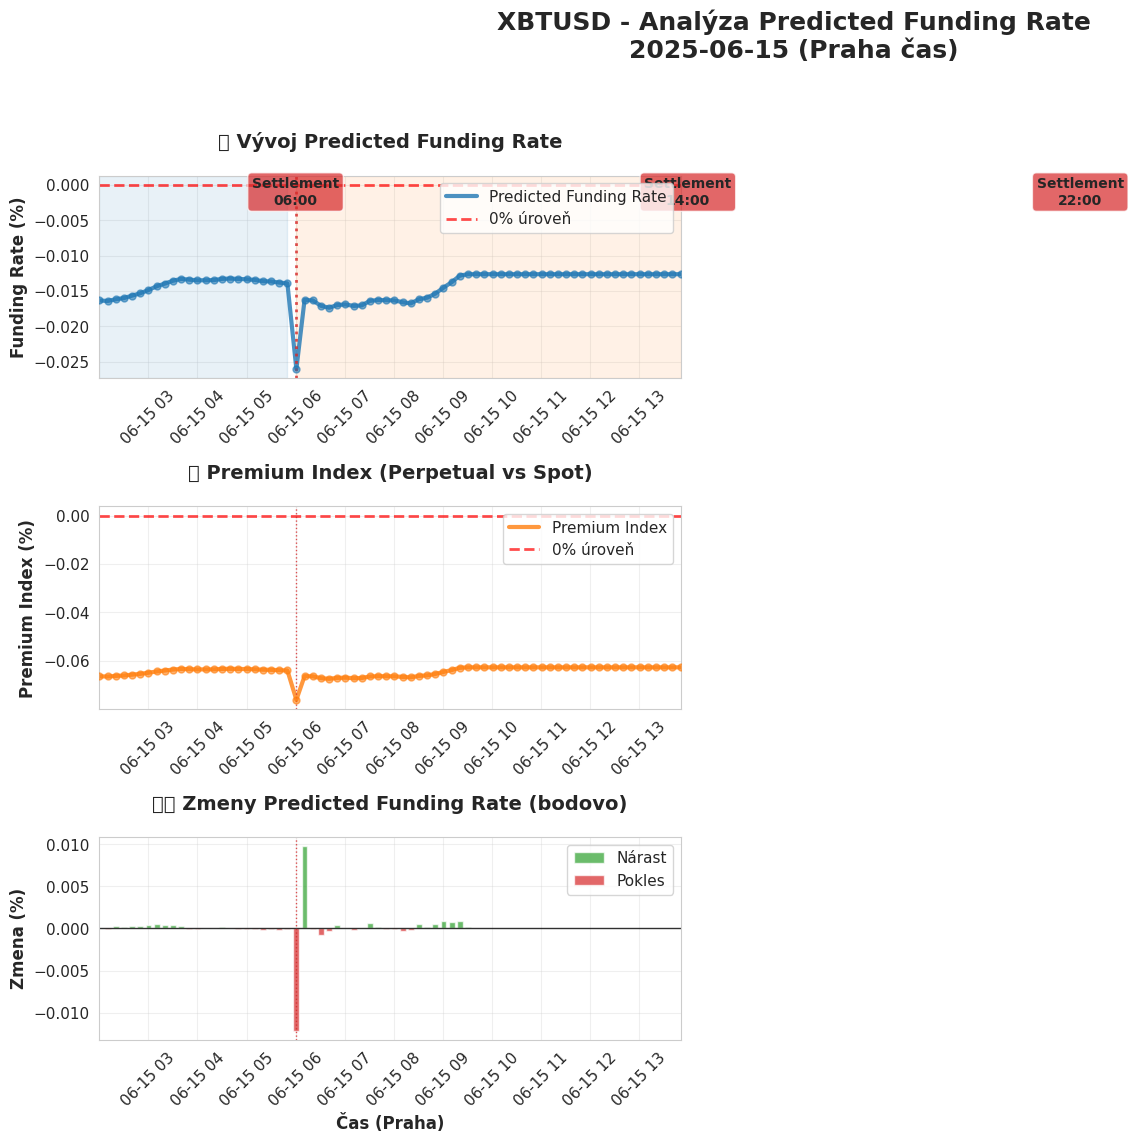


📊 DETAILNÉ ŠTATISTIKY:
🔺 Maximum predicted funding: -0.0126%
🔻 Minimum predicted funding: -0.0261%
📈 Priemer: -0.0143%
📊 Štandardná odchýlka: 0.0022%
📏 Rozpätie: 0.0134%

🚀 EXTRÉMNE HODNOTY:
📈 Najväčší nárast: 0.0098% o 06:11
📉 Najväčší pokles: -0.0121% o 06:01
⏰ Najvyššia funding rate: 09:31
⏰ Najnižšia funding rate: 06:01

📋 DETAILNÁ TABUĽKA VÝVOJA PREDICTED FUNDING RATE - XBTUSD
Čas (Praha)  Funding %  Premium %   Zmena %   Trend  Dát.body   Cieľ    
--------------------------------------------------------------------------------------------------------------
02:00        -0.0163    -0.0663     ---       ➡️     241        06:00   
02:10        -0.0164    -0.0664     -0.0001   ➡️     251        06:00   
02:20        -0.0162    -0.0662     +0.0002   📈      261        06:00   
02:30        -0.0160    -0.0660     +0.0002   📈      271        06:00   
02:40        -0.0157    -0.0657     +0.0003   📈      281        06:00   
02:50        -0.0153    -0.0653     +0.0003   📈      291        0

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
import warnings
warnings.filterwarnings('ignore')

# Nastavenie pre pekné grafy
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

def get_funding_settlements_for_day(date_str="2025-06-15"):
    """Získa funding settlement časy pre daný deň"""
    settlements = []
    base_date = datetime.strptime(date_str, "%Y-%m-%d").replace(tzinfo=timezone.utc)
    
    # Funding časy: 04:00, 12:00, 20:00 UTC
    for hour in [4, 12, 20]:
        settlement_time = base_date.replace(hour=hour, minute=0, second=0, microsecond=0)
        settlements.append(settlement_time)
    
    return settlements

def calculate_predicted_funding_at_time(symbol, target_time, settlement_start):
    """Vypočíta predicted funding rate v konkrétnom čase"""
    
    # Časové okno od settlement do target_time
    start_time = settlement_start.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    end_time = target_time.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    try:
        # Počet minút v okne + buffer
        time_diff = target_time - settlement_start
        minutes_needed = int(time_diff.total_seconds() / 60) + 10
        count = min(minutes_needed, 500)
        
        # Získaj Premium Index dáta
        url_pi = f"https://www.bitmex.com/api/v1/trade?symbol=.{symbol}PI&count={count}&reverse=true&endTime={end_time}"
        resp_pi = requests.get(url_pi)
        
        if resp_pi.status_code != 200:
            return None
            
        pi_data = resp_pi.json()
        if not pi_data:
            return None
        
        # Spracuj dáta
        df_pi = pd.DataFrame(pi_data)
        df_pi['timestamp'] = pd.to_datetime(df_pi['timestamp'])
        
        # Filtruj dáta od settlement_start do target_time
        df_pi_filtered = df_pi[
            (df_pi['timestamp'] >= settlement_start) & 
            (df_pi['timestamp'] <= target_time)
        ]
        
        if df_pi_filtered.empty:
            return None
        
        # Vypočítaj priemer Premium Index
        avg_premium_index = df_pi_filtered['price'].mean()
        data_points = len(df_pi_filtered)
        
        # Aplikuj BitMEX vzorec
        interest_rate = 0.0001  # 0.01%
        diff = interest_rate - avg_premium_index
        clamped_value = max(-0.0005, min(0.0005, diff))
        predicted_funding = avg_premium_index + clamped_value
        
        return {
            'timestamp': target_time,
            'predicted_funding': predicted_funding,
            'predicted_funding_percent': predicted_funding * 100,
            'premium_index': avg_premium_index,
            'data_points': data_points,
            'hours_since_settlement': time_diff.total_seconds() / 3600
        }
        
    except Exception as e:
        print(f"Chyba pre čas {target_time}: {e}")
        return None

def analyze_funding_evolution(symbol="XBTUSD", date_str="2025-06-15", interval_minutes=10):
    """Analyzuje vývoj predicted funding rate počas dňa s hustejšími meraniami"""
    
    print(f"📊 Analyzujem vývoj predicted funding rate pre {symbol} dňa {date_str}")
    print("=" * 80)
    
    # Získaj settlement časy pre daný deň
    settlements = get_funding_settlements_for_day(date_str)
    
    # Začiatok analýzy - polnoc
    start_analysis = datetime.strptime(f"{date_str} 00:00:01", "%Y-%m-%d %H:%M:%S").replace(tzinfo=timezone.utc)
    
    all_results = []
    
    # Pre každé settlement okno
    for i, settlement in enumerate(settlements):
        print(f"\n🕐 Analyzujem okno {i+1}: Settlement {settlement.strftime('%H:%M')} UTC")
        
        # Časové body pre analýzu v tomto okne
        if i == 0:
            # Pre prvé okno začneme od polnoci
            window_start = start_analysis
        else:
            # Pre ostatné okná začneme hneď po predchádzajúcom settlement
            window_start = settlements[i-1] + timedelta(minutes=1)
        
        window_end = settlement
        
        # Generuj časové body každých X minút
        current_time = window_start
        window_results = []
        
        while current_time < window_end:
            # Zisti ktorý settlement používať pre výpočet
            settlement_for_calc = settlements[i-1] if i > 0 else settlements[-1] - timedelta(days=1)
            if i == 0:
                # Pre prvé okno používame settlement z predchádzajúceho dňa (20:00)
                settlement_for_calc = settlement_for_calc.replace(hour=20)
            
            result = calculate_predicted_funding_at_time(symbol, current_time, settlement_for_calc)
            if result:
                result['settlement_target'] = settlement
                result['window'] = i + 1
                window_results.append(result)
                all_results.append(result)
            
            current_time += timedelta(minutes=interval_minutes)
        
        print(f"✅ Získané {len(window_results)} dátových bodov pre okno {i+1}")
    
    if not all_results:
        print("❌ Žiadne dáta získané")
        return None
    
    # Vytvor DataFrame
    df_results = pd.DataFrame(all_results)
    df_results['timestamp'] = pd.to_datetime(df_results['timestamp'])
    df_results['time_prague'] = df_results['timestamp'].dt.tz_convert('Europe/Prague')
    
    print(f"\n📈 Celkovo získaných {len(df_results)} dátových bodov")
    print(f"📅 Od: {df_results['timestamp'].min()}")
    print(f"📅 Do: {df_results['timestamp'].max()}")
    
    return df_results

def create_beautiful_funding_chart(df_results, symbol="XBTUSD", date_str="2025-06-15"):
    """Vytvorí krásny graf s krývkami vývoja predicted funding rate"""
    
    if df_results is None or df_results.empty:
        print("❌ Žiadne dáta na vizualizáciu")
        return
    
    # Vytvor figure s viacerými subplotmi
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    fig.suptitle(f'{symbol} - Analýza Predicted Funding Rate\n{date_str} (Praha čas)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Farebná paleta
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # ===== GRAF 1: Predicted Funding Rate =====
    ax1 = axes[0]
    
    # Hlavná krývka
    ax1.plot(df_results['time_prague'], df_results['predicted_funding_percent'], 
             color=colors[0], linewidth=3, alpha=0.8, label='Predicted Funding Rate')
    
    # Bodky pre lepšiu viditeľnosť
    ax1.scatter(df_results['time_prague'], df_results['predicted_funding_percent'], 
                color=colors[0], s=25, alpha=0.6, zorder=5)
    
    # Nulová čiara
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='0% úroveň')
    
    # Settlement časy (Praha čas: 06:00, 14:00, 22:00)
    settlement_times_prague = [6, 14, 22]
    for i, hour in enumerate(settlement_times_prague):
        settlement_time = df_results['time_prague'].iloc[0].replace(hour=hour, minute=0, second=0)
        ax1.axvline(x=settlement_time, color=colors[3], linestyle=':', alpha=0.8, linewidth=2)
        ax1.text(settlement_time, ax1.get_ylim()[1]*0.85, f'Settlement\n{hour:02d}:00', 
                ha='center', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[3], alpha=0.7, edgecolor='white'))
    
    ax1.set_title('📈 Vývoj Predicted Funding Rate', fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Funding Rate (%)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper right')
    
    # Farebné pozadie pre rôzne okná
    for i, window_num in enumerate([1, 2, 3]):
        window_data = df_results[df_results['window'] == window_num]
        if not window_data.empty:
            ax1.axvspan(window_data['time_prague'].min(), window_data['time_prague'].max(), 
                       alpha=0.1, color=colors[i % len(colors)], label=f'Okno {window_num}')
    
    # ===== GRAF 2: Premium Index =====
    ax2 = axes[1]
    
    # Premium Index krývka
    ax2.plot(df_results['time_prague'], df_results['premium_index']*100, 
             color=colors[1], linewidth=3, alpha=0.8, label='Premium Index')
    
    # Bodky
    ax2.scatter(df_results['time_prague'], df_results['premium_index']*100, 
                color=colors[1], s=25, alpha=0.6, zorder=5)
    
    # Nulová čiara
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='0% úroveň')
    
    # Settlement čiary
    for hour in settlement_times_prague:
        settlement_time = df_results['time_prague'].iloc[0].replace(hour=hour, minute=0, second=0)
        ax2.axvline(x=settlement_time, color=colors[3], linestyle=':', alpha=0.8, linewidth=1)
    
    ax2.set_title('📊 Premium Index (Perpetual vs Spot)', fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('Premium Index (%)', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')
    
    # ===== GRAF 3: Zmeny Funding Rate =====
    ax3 = axes[2]
    
    # Vypočítaj zmeny
    df_results_copy = df_results.copy()
    df_results_copy['funding_change'] = df_results_copy['predicted_funding_percent'].diff()
    
    # Pozitívne a negatívne zmeny rôznymi farbami
    positive_changes = df_results_copy['funding_change'] > 0
    negative_changes = df_results_copy['funding_change'] < 0
    
    # Stĺpcový graf zmien
    ax3.bar(df_results_copy.loc[positive_changes, 'time_prague'], 
            df_results_copy.loc[positive_changes, 'funding_change'],
            color=colors[2], alpha=0.7, label='Nárast', width=0.005)
    
    ax3.bar(df_results_copy.loc[negative_changes, 'time_prague'], 
            df_results_copy.loc[negative_changes, 'funding_change'],
            color=colors[3], alpha=0.7, label='Pokles', width=0.005)
    
    # Nulová čiara
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
    
    # Settlement čiary
    for hour in settlement_times_prague:
        settlement_time = df_results['time_prague'].iloc[0].replace(hour=hour, minute=0, second=0)
        ax3.axvline(x=settlement_time, color=colors[3], linestyle=':', alpha=0.8, linewidth=1)
    
    ax3.set_title('📈📉 Zmeny Predicted Funding Rate (bodovo)', fontsize=14, fontweight='bold', pad=20)
    ax3.set_ylabel('Zmena (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Čas (Praha)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc='upper right')
    
    # Formátovanie času na x-osi
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlim(df_results['time_prague'].min(), df_results['time_prague'].max())
    
    # Lepší layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Štatistiky
    print("\n📊 DETAILNÉ ŠTATISTIKY:")
    print("=" * 60)
    print(f"🔺 Maximum predicted funding: {df_results['predicted_funding_percent'].max():.4f}%")
    print(f"🔻 Minimum predicted funding: {df_results['predicted_funding_percent'].min():.4f}%")
    print(f"📈 Priemer: {df_results['predicted_funding_percent'].mean():.4f}%")
    print(f"📊 Štandardná odchýlka: {df_results['predicted_funding_percent'].std():.4f}%")
    print(f"📏 Rozpätie: {df_results['predicted_funding_percent'].max() - df_results['predicted_funding_percent'].min():.4f}%")
    
    # Najväčšie zmeny
    if 'funding_change' in df_results_copy.columns:
        max_increase_idx = df_results_copy['funding_change'].idxmax()
        max_decrease_idx = df_results_copy['funding_change'].idxmin()
        
        max_increase = df_results_copy.loc[max_increase_idx]
        max_decrease = df_results_copy.loc[max_decrease_idx]
        
        print(f"\n🚀 EXTRÉMNE HODNOTY:")
        print(f"📈 Najväčší nárast: {max_increase['funding_change']:.4f}% o {max_increase['time_prague'].strftime('%H:%M')}")
        print(f"📉 Najväčší pokles: {max_decrease['funding_change']:.4f}% o {max_decrease['time_prague'].strftime('%H:%M')}")
        
        # Časy kedy bola funding rate najvyššia/najnižšia
        max_funding_time = df_results.loc[df_results['predicted_funding_percent'].idxmax(), 'time_prague']
        min_funding_time = df_results.loc[df_results['predicted_funding_percent'].idxmin(), 'time_prague']
        
        print(f"⏰ Najvyššia funding rate: {max_funding_time.strftime('%H:%M')}")
        print(f"⏰ Najnižšia funding rate: {min_funding_time.strftime('%H:%M')}")

def create_funding_table(df_results, symbol="XBTUSD"):
    """Vytvorí detailnú tabuľku s vývoj predicted funding rate"""
    
    if df_results is None or df_results.empty:
        print("❌ Žiadne dáta pre tabuľku")
        return None
    
    print(f"\n📋 DETAILNÁ TABUĽKA VÝVOJA PREDICTED FUNDING RATE - {symbol}")
    print("=" * 110)
    
    # Priprav tabuľku s potrebnými stĺpcami
    table_df = df_results.copy()
    table_df['funding_change'] = table_df['predicted_funding_percent'].diff()
    table_df['funding_change_abs'] = table_df['funding_change'].abs()
    
    # Určenie trendu
    def get_trend(change):
        if pd.isna(change) or abs(change) < 0.0001:
            return "➡️"
        elif change > 0:
            return "📈"
        else:
            return "📉"
    
    table_df['trend'] = table_df['funding_change'].apply(get_trend)
    
    # Určenie settlement targetu
    def get_next_settlement(timestamp):
        hour = timestamp.hour
        if hour < 6:
            return "06:00"
        elif hour < 14:
            return "14:00"
        else:
            return "22:00"
    
    table_df['next_settlement'] = table_df['time_prague'].apply(get_next_settlement)
    
    # Vytvor prehľadnú tabuľku
    print(f"{'Čas (Praha)':<12} {'Funding %':<10} {'Premium %':<11} {'Zmena %':<9} {'Trend':<6} {'Dát.body':<10} {'Cieľ':<8}")
    print("-" * 110)
    
    for _, row in table_df.iterrows():
        funding_str = f"{row['predicted_funding_percent']:.4f}"
        premium_str = f"{row['premium_index']*100:.4f}"
        
        if pd.isna(row['funding_change']):
            change_str = "---"
        else:
            change_str = f"{row['funding_change']:+.4f}"
        
        print(f"{row['time_prague'].strftime('%H:%M'):<12} "
              f"{funding_str:<10} "
              f"{premium_str:<11} "
              f"{change_str:<9} "
              f"{row['trend']:<6} "
              f"{row['data_points']:<10} "
              f"{row['next_settlement']:<8}")
    
    # Súhrn pre každé settlement okno
    print("\n" + "=" * 110)
    print("📊 SÚHRN PO SETTLEMENT OKNÁCH:")
    print("-" * 70)
    
    for window_num in sorted(table_df['window'].unique()):
        window_data = table_df[table_df['window'] == window_num]
        
        if not window_data.empty:
            start_time = window_data['time_prague'].min().strftime('%H:%M')
            end_time = window_data['time_prague'].max().strftime('%H:%M')
            avg_funding = window_data['predicted_funding_percent'].mean()
            min_funding = window_data['predicted_funding_percent'].min()
            max_funding = window_data['predicted_funding_percent'].max()
            total_change = window_data['predicted_funding_percent'].iloc[-1] - window_data['predicted_funding_percent'].iloc[0]
            
            print(f"\n🕐 OKNO {window_num}: {start_time} - {end_time}")
            print(f"   📈 Priemer: {avg_funding:.4f}%")
            print(f"   🔺 Maximum: {max_funding:.4f}%") 
            print(f"   🔻 Minimum: {min_funding:.4f}%")
            print(f"   📊 Celková zmena: {total_change:+.4f}%")
            print(f"   📝 Počet meraní: {len(window_data)}")
    
    # Export do CSV pre ďalšie použitie
    export_df = table_df[['time_prague', 'predicted_funding_percent', 'premium_index', 
                         'funding_change', 'data_points', 'window', 'next_settlement']].copy()
    export_df.columns = ['Cas_Praha', 'Predicted_Funding_%', 'Premium_Index', 
                        'Zmena_%', 'Pocet_dat', 'Okno', 'Ciel_Settlement']
    
    filename = f"predicted_funding_table_{symbol}_{table_df['time_prague'].iloc[0].strftime('%Y%m%d')}.csv"
    export_df.to_csv(filename, index=False)
    print(f"\n💾 Tabuľka exportovaná do: {filename}")
    
    return export_df

def get_actual_funding_rates(symbol="XBTUSD", date_str="2025-06-15"):
    """Získa skutočné funding rates pre porovnanie"""
    
    start_date = f"{date_str}T00:00:00.000Z"
    end_date = f"{date_str}T23:59:59.000Z"
    
    url = f"https://www.bitmex.com/api/v1/funding?symbol={symbol}&startTime={start_date}&endTime={end_date}&reverse=false"
    
    try:
        resp = requests.get(url)
        if resp.status_code == 200:
            funding_data = resp.json()
            df_actual = pd.DataFrame(funding_data)
            if not df_actual.empty:
                df_actual['timestamp'] = pd.to_datetime(df_actual['timestamp'])
                df_actual['time_prague'] = df_actual['timestamp'].dt.tz_convert('Europe/Prague')
                df_actual['funding_percent'] = df_actual['fundingRate'] * 100
                
                print("\n💰 SKUTOČNÉ FUNDING RATES:")
                print("-" * 50)
                for _, row in df_actual.iterrows():
                    print(f"⏰ {row['time_prague'].strftime('%H:%M')} - {row['funding_percent']:.4f}%")
                
                return df_actual
            else:
                print("❌ Žiadne funding dáta pre tento deň")
                return None
        else:
            print(f"❌ Chyba pri získavaní funding rates: {resp.status_code}")
            return None
    except Exception as e:
        print(f"❌ Chyba: {e}")
        return None

def run_visual_analysis(symbol="XBTUSD", date_str="2025-06-15", interval_minutes=10):
    """Spustí vizuálnu analýzu s krásnymi grafmi"""
    
    print(f"🎨 SPÚŠŤAM VIZUÁLNU ANALÝZU PRE {symbol}")
    print(f"📅 Dátum: {date_str}")
    print(f"⏱️ Interval: {interval_minutes} minút")
    print("=" * 80)
    
    # 1. Analyzuj vývoj predicted funding rate
    df_results = analyze_funding_evolution(symbol, date_str, interval_minutes)
    
    if df_results is not None:
        # 2. Vytvor krásne grafy
        create_beautiful_funding_chart(df_results, symbol, date_str)
        
        # 3. Vytvor detailnú tabuľku
        table_df = create_funding_table(df_results, symbol)
        
        # 4. Získaj skutočné funding rates pre porovnanie
        df_actual = get_actual_funding_rates(symbol, date_str)
        
        return df_results, df_actual, table_df
    else:
        return None, None, None

# SPUSTENIE VIZUÁLNEJ ANALÝZY
if __name__ == "__main__":
    # Spusti vizuálnu analýzu pre 2025-06-15
    df_predicted, df_actual, table_df = run_visual_analysis("XBTUSD", "2025-06-15", 10)